# LM PPL for Simplification?

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import math
import torch
import os
import numpy as np
from tqdm.notebook import tqdm

from transformers import GPT2TokenizerFast, GPT2LMHeadModel

In [2]:
# Load pre-trained model (weights)
model = GPT2LMHeadModel.from_pretrained('distilgpt2')
model.eval()
print(f'Model is loaded on {model.device}')
# Load pre-trained model tokenizer (vocabulary)
tokenizer = GPT2TokenizerFast.from_pretrained('distilgpt2')

Model is loaded on cpu


In [3]:
def distilGPT2_perplexity_score(sentence):
    sentence = sentence.strip()
    if not sentence:
        return np.nan # for empty string
    else:
        tokenize_input = tokenizer.tokenize(sentence)
        tensor_input = torch.tensor(
            [tokenizer.convert_tokens_to_ids(tokenize_input)])
        loss, logits = model(tensor_input, labels=tensor_input)[:2]
        return math.exp(loss)
    
def read_split_lines(filename, split_sep='<::::>'):
    """from easse/utils/helpers.py"""
    with open(filename, encoding="utf-8") as f:
        split_instances = []
        for line in f:
            split_instances.append([split.strip() for split in line.split(split_sep)])

    return split_instances

In [8]:
# human simplifications

# filepath = '/srv/scratch6/kew/ats/data/en/aligned/turk_test.tsv'
filepath = '/srv/scratch6/kew/ats/data/en/aligned/asset_test.tsv'
test_set = filepath.split('/')[-1].split('.')[0].replace('_', ' ').title()
print(test_set)
sents = read_split_lines(filepath, split_sep='\t')
complex_sents = [i[0] for i in sents]
simple_sents = [i[1:] for i in sents]
simple_sents = list(map(list, [*zip(*simple_sents)]))

assert len(complex_sents) == len(simple_sents[0])

Asset Test


In [9]:
complex_ppls = [distilGPT2_perplexity_score('. '+s) for s in tqdm(complex_sents)]

  0%|          | 0/359 [00:00<?, ?it/s]

In [10]:
print(f'Computing ppl for {len(simple_sents)} sets of simplified sentences ...')
simple_ppls = []
for sents in simple_sents:
    simple_ppls.append([distilGPT2_perplexity_score('. '+s) for s in tqdm(sents)])

Computing ppl for 10 sets of simplified sentences ...


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

In [11]:
print(type(complex_ppls))
print(len(complex_ppls))
print(type(simple_ppls))
print(len(simple_ppls))
print(len(simple_ppls[0]))

<class 'list'>
359
<class 'list'>
10
359


In [12]:
ppls = np.concatenate([[complex_ppls], simple_ppls])
print(ppls.shape)

(11, 359)


In [13]:
print(ppls)
print(ppls[0].shape)

[[ 70.89087884  21.04061606 117.5404211  ...  56.86862754  63.31177236
  157.44073937]
 [ 66.39922513  65.71630579 227.79982293 ... 110.94069942  50.47243017
  219.53913622]
 [ 53.4560543   25.34978992  98.43735132 ...  59.4276563   68.11250945
  188.56024406]
 ...
 [ 63.39058553  28.36398457 123.92533662 ... 139.23536989 112.75516345
   80.6782542 ]
 [ 54.5471724   37.63120419 214.98930928 ...  85.36479219  45.22913017
   85.03810913]
 [ 40.79078825  23.30721435 126.82537086 ...  56.31226709  81.83020229
  133.20306791]]
(359,)


In [14]:
names = ['complex'] + ['simple_'+str(i+1) for i in range(len(simple_ppls))]
print(names)
df = pd.DataFrame(ppls.transpose(), columns=names)
df

['complex', 'simple_1', 'simple_2', 'simple_3', 'simple_4', 'simple_5', 'simple_6', 'simple_7', 'simple_8', 'simple_9', 'simple_10']


,complex,simple_1,simple_2,simple_3,simple_4,simple_5,simple_6,simple_7,simple_8,simple_9,simple_10
0,70.890879,66.399225,53.456054,79.208655,58.947869,47.245793,47.042113,64.224607,63.390586,54.547172,40.790788
1,21.040616,65.716306,25.349790,54.682880,20.831591,21.959347,46.756367,22.318817,28.363985,37.631204,23.307214
2,117.540421,227.799823,98.437351,144.385731,98.957344,90.787495,166.183629,94.458317,123.925337,214.989309,126.825371
3,58.360285,115.894390,53.260701,108.595315,65.700796,49.509565,156.670274,50.579739,67.494728,52.924373,548.648992
4,64.186704,52.386125,61.741792,70.886924,118.470041,156.999775,68.763909,89.259901,78.731406,63.175523,73.679217
...,...,...,...,...,...,...,...,...,...,...,...
354,46.568696,113.008847,108.545253,95.077084,91.724829,81.236342,53.898814,81.715993,49.155642,53.792748,137.783090
355,436.152920,461.435459,320.043809,342.678915,588.530530,254.805169,149.895264,374.362397,407.539377,198.835452,274.625781
356,56.868628,110.940699,59.427656,145.914005,38.803925,46.191007,79.371382,57.487583,139.235370,85.364792,56.312267
357,63.311772,50.472430,68.112509,105.307453,76.208261,79.560199,60.413149,58.769146,112.755163,45.229130,81.830202


In [15]:
# df.min()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   complex    359 non-null    float64
 1   simple_1   359 non-null    float64
 2   simple_2   359 non-null    float64
 3   simple_3   359 non-null    float64
 4   simple_4   359 non-null    float64
 5   simple_5   359 non-null    float64
 6   simple_6   359 non-null    float64
 7   simple_7   359 non-null    float64
 8   simple_8   359 non-null    float64
 9   simple_9   359 non-null    float64
 10  simple_10  359 non-null    float64
dtypes: float64(11)
memory usage: 31.0 KB


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'LM PPL on Asset Test Set')

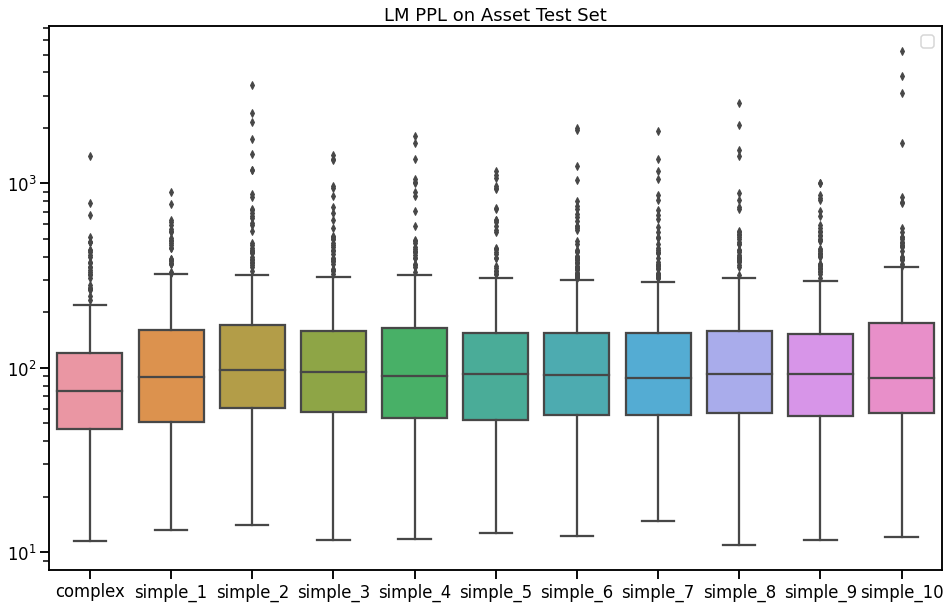

In [21]:
sns.set_context('talk')

fig, ax = plt.subplots(1,1,figsize=(16,10))
ax = sns.boxplot(data=df)
# ax.set_xlim(left=None, right=1000)
# ax.set_ylim(bottom=0, top=1000)
plt.legend()
ax.set(yscale="log")

plt.title(f'LM PPL on {test_set} Set')
